# Turbofan engine degradation: train models

# Import modules

In [1]:
import os
import sys
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# tools for this dev
import downloadDataset

# AWS tools
import boto3
import sagemaker

# Load dataset

The dataset can be downloaded by running the script ``downloadDataset.py``. Here, we run the main function of this script to download and prepare the dataset.

In [2]:
# user parameters
dataDir = '/home/ubuntu/datasets/Turbofan engine degradation simulation'
overwrite = True

# download and prepare
downloadDataset.main(dataDir,overwrite)

remove existing taget directory "/home/ubuntu/datasets/Turbofan engine degradation simulation"


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/urllib3/connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


reading and processing file train_FD001.txt
reading and processing file train_FD002.txt
reading and processing file train_FD003.txt
reading and processing file train_FD004.txt
reading and processing file test_FD001.txt
reading and processing file test_FD002.txt
reading and processing file test_FD003.txt
reading and processing file test_FD004.txt
writing assembled dataset to "/home/ubuntu/datasets/Turbofan engine degradation simulation/assembledDataset.csv"


In [3]:
# read the dataset
dataFile = 'assembledDataset.csv'
dset = pd.read_csv(os.path.join(dataDir,dataFile))
dset.head()

,id,cycle,setting1,setting2,setting3,s1,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,s5,...,s18,s19,HPTCoolantBleed,LPTCoolantBleed,source,org_id,conditions,fault_modes,RUL,fail
0,1167,77,-0.0000,0.0002,100.0,518.67,642.04,1585.41,1391.29,14.62,...,2388,100.0,38.76,23.3778,test_FD003.txt,99,ONE (Sea Level),"TWO (HPC Degradation, Fan Degradation)",220,0
1,110,141,35.0047,0.8400,100.0,449.44,555.70,1367.62,1136.74,5.48,...,2223,100.0,14.99,8.8820,train_FD002.txt,10,SIX,ONE (HPC Degradation),43,0
2,586,44,35.0002,0.8417,100.0,449.44,554.81,1355.55,1119.00,5.48,...,2223,100.0,14.85,8.8715,train_FD004.txt,126,SIX,"TWO (HPC Degradation, Fan Degradation)",258,0
3,1330,4,0.0021,0.0015,100.0,518.67,642.12,1593.18,1401.88,14.62,...,2388,100.0,38.96,23.4011,test_FD004.txt,162,SIX,"TWO (HPC Degradation, Fan Degradation)",179,0
4,594,77,42.0040,0.8400,100.0,445.00,549.12,1346.28,1124.56,3.91,...,2212,100.0,10.53,6.5035,train_FD004.txt,134,SIX,"TWO (HPC Degradation, Fan Degradation)",170,0


In [4]:
print('nb of available engines per op condidtions and fault modes (fault mode generally unkown):')
df = dset.groupby(['conditions','fault_modes'])[['id']].nunique()
df.columns = ['nb engines']
df

nb of available engines per op condidtions and fault modes (fault mode generally unkown):


nb engines
conditions      fault_modes                                       
ONE (Sea Level) ONE (HPC Degradation)                          200
                TWO (HPC Degradation, Fan Degradation)         200
SIX             ONE (HPC Degradation)                          519
                TWO (HPC Degradation, Fan Degradation)         497

In [5]:
dset.columns

Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1',
       'LPCOutletTemp', 'HPCOutletTemp', 'LPTOutletTemp', 's5', 's6',
       'TotalHPCOutletPres', 'PhysFanSpeed', 'PhysCoreSpeed', 's10',
       'StaticHPCOutletPres', 'FuelFlowRatio', 'corrFanSpeed', 'coorCoreSpeed',
       'BypassRatio', 's16', 'BleedEntropy', 's18', 's19', 'HPTCoolantBleed',
       'LPTCoolantBleed', 'source', 'org_id', 'conditions', 'fault_modes',
       'RUL', 'fail'],
      dtype='object')

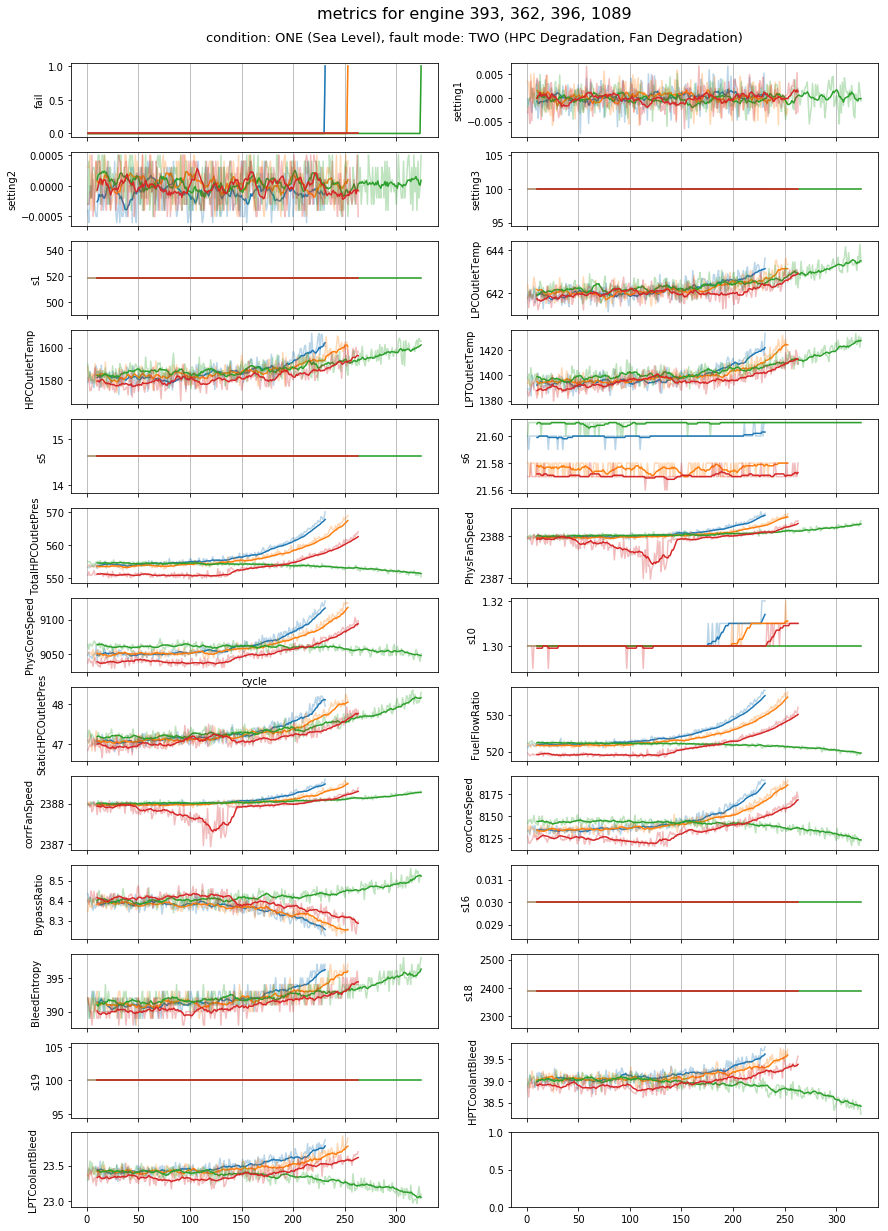

In [6]:
# user parameters
nbEngines = 4
conditions = 'ONE (Sea Level)'
# conditions = 'SIX'
# fault_modes = 'ONE (HPC Degradation)'
fault_modes = 'TWO (HPC Degradation, Fan Degradation)'
columnToPLot = [
    'fail',
    'setting1','setting2','setting3',
    's1','LPCOutletTemp','HPCOutletTemp','LPTOutletTemp','s5','s6',
    'TotalHPCOutletPres','PhysFanSpeed','PhysCoreSpeed','s10',
    'StaticHPCOutletPres','FuelFlowRatio','corrFanSpeed','coorCoreSpeed',
    'BypassRatio','s16','BleedEntropy','s18','s19','HPTCoolantBleed',
    'LPTCoolantBleed'
]
movingAvgWindow = 10
nCols = 2

def plotTimeSeries(nbEngines,conditions,fault_modes,movingAvgWindow=10,nCols=2):
    # auto parameters
    nRows = int(np.ceil(len(columnToPLot)/nCols))
    mask = (dset['conditions']==conditions) & (dset['fault_modes']==fault_modes)
    engineIds = dset.loc[mask,'id'].sample(n=nbEngines).values

    # plot
    fig,axs = plt.subplots(nrows=nRows,ncols=nCols,sharex=True,figsize=[14,1.5*nRows])

    for engId in engineIds:
        mask = dset['id']==engId
        dat = dset.loc[mask].sort_values(by='cycle')
        xs = dat['cycle']
        for i,(ax,col) in enumerate(zip(axs.reshape(-1),columnToPLot)):
            ys = dat[col]
            p = ax.plot(xs,ys,alpha=0.3)
            color = p[0].get_color()
            ys_rolAvg = dat[col].rolling(window=movingAvgWindow).mean()
            if col=='fail':
                ys_rolAvg = dat[col]
            ax.plot(xs,ys_rolAvg,color=color)
            ax.grid(True,axis='x')
            ax.set_ylabel(col)
            if i==nRows-1:
                ax.set_xlabel('cycle')

    fig.suptitle(
        t='metrics for engine {}'.format(', '.join([str(i) for i in engineIds])),
        fontsize=16
    )
    fig.text(
        x=0.5,
        y=0.955,
        s='condition: {}, fault mode: {}'.format(conditions,fault_modes),
        horizontalalignment='center',
        fontsize=13
    )
    plt.subplots_adjust(left=0.1,top=0.94)
    
plotTimeSeries(nbEngines,conditions,fault_modes)

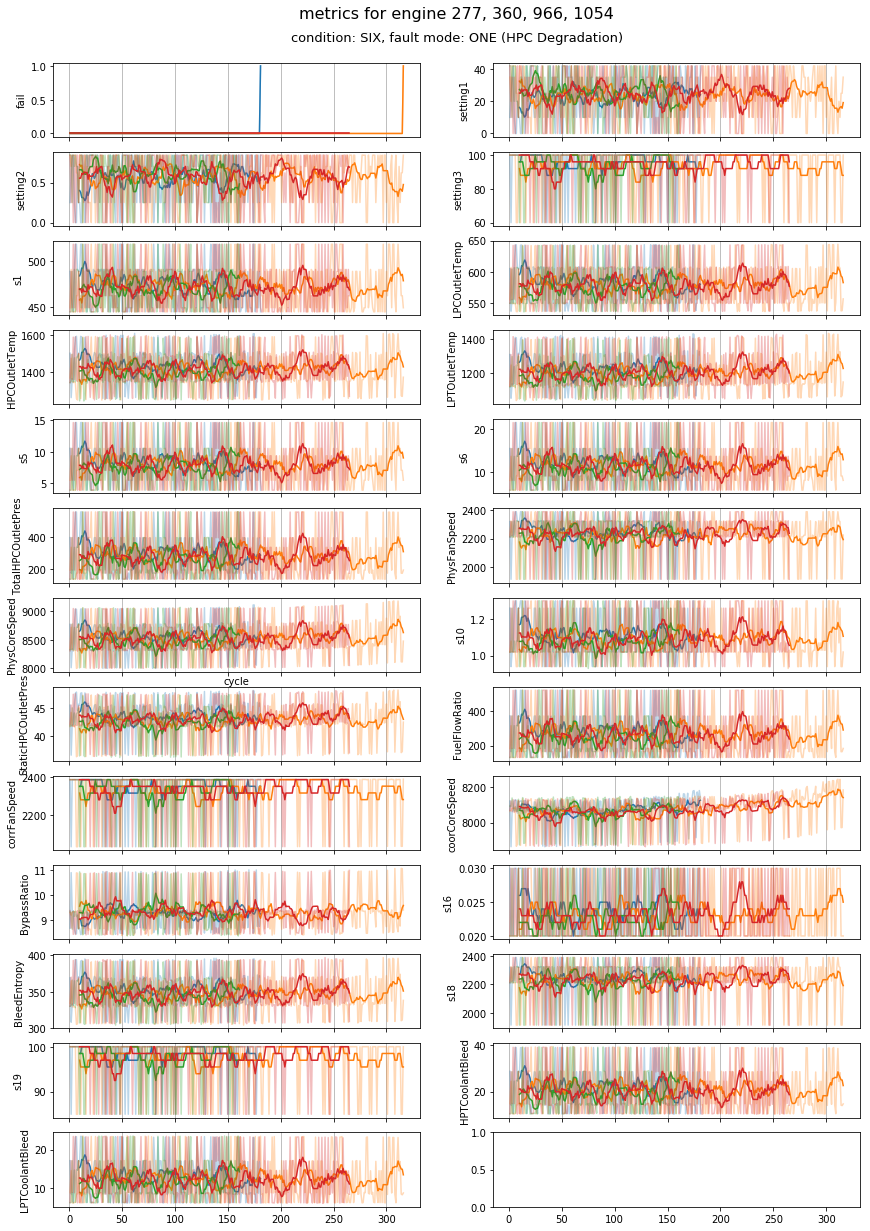

In [7]:
# conditions = 'ONE (Sea Level)'
conditions = 'SIX'
fault_modes = 'ONE (HPC Degradation)'
# fault_modes = 'TWO (HPC Degradation, Fan Degradation)'
plotTimeSeries(nbEngines,conditions,fault_modes)

In [8]:
def plotCrossCoor(df,figsize=[10,10],nanThreshold=None):
    '''
    Function plots the cross-correlation matrix for each column pair in a 
    dataframe (df). 

    Arguments
    ---------
    df: pandas DataFrame
    figsize: list of two positive numerics
        Size of the figure
    nanThreshold: float between 0 and 1. Default=None
        if the cross-correlation c>nanThreshold or c<-nanThreshold, c is set to 
        np.nan. The idea is to flag high correlation and anti-correlation. If 
        nanThreshold=None, no threshold applied.
    '''
    fig, ax = plt.subplots(figsize=figsize)
    
    corr = df.corr()
    corr[np.triu(np.ones_like(corr),k=1)==1] = np.nan
    if nanThreshold!=None:
        corr[corr>abs(nanThreshold)] = np.nan
        corr[corr<-abs(nanThreshold)] = np.nan
    im = ax.imshow(corr,cmap='RdBu_r')
    plt.colorbar(im)
    ax.set_xticks(range(len(df.columns)))
    ax.set_xticklabels(df.columns)
    ax.set_yticks(range(len(df.columns)))
    ax.set_yticklabels(df.columns)
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Cross-correlation matrix',fontsize=14)
    
    return fig,ax

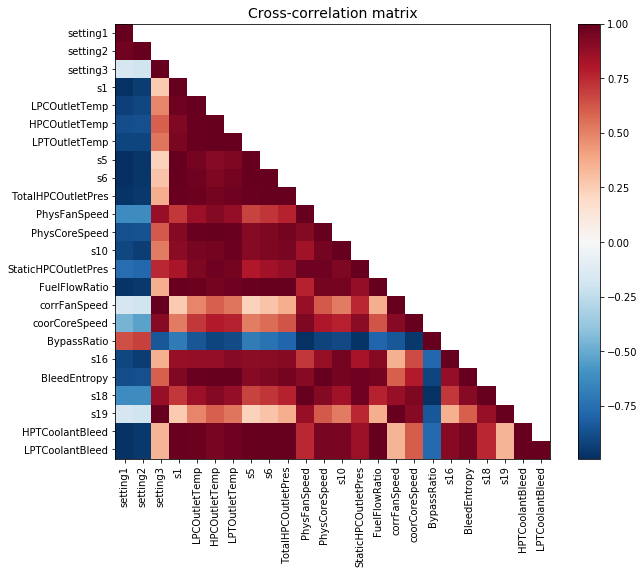

In [9]:
columnToCorr = [
    'setting1','setting2','setting3',
    's1','LPCOutletTemp','HPCOutletTemp','LPTOutletTemp','s5','s6',
    'TotalHPCOutletPres','PhysFanSpeed','PhysCoreSpeed','s10',
    'StaticHPCOutletPres','FuelFlowRatio','corrFanSpeed','coorCoreSpeed',
    'BypassRatio','s16','BleedEntropy','s18','s19','HPTCoolantBleed',
    'LPTCoolantBleed'
]
fig,ax = plotCrossCoor(dset[columnToCorr],figsize=[10,8],nanThreshold=None)

Some sensor values are highly correlated, they might not bring much in the regression models we will train later on:
* LPTCoolantBleed: its values are moslty similar to HPTCoolantBleed, which is not suprising as they are both coming from the turbine.
* LPCOutletTemp: highly correlated to the compressor outlet temprature, which is not a surprise. Nevertheless, removing it might not be a good idea as it represent a very different part of a turbofan, which might be subject to different failure modes.
* S5 and S6: They are highly correlated to the Tolal high pressure compressor outlet pressure (TotalHPCOutletPres). I suspect that these sensor are Total pressure measured at the LPC and LTP outlet.

# Train models: non auto-regressive

In [10]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

## Prepare dataset

In [11]:
import io
import sagemaker.amazon.common as smac

In [12]:
# where the model and the datasets used for training and validation will be 
# stored
bucket = 'vonlanth-development'

# role used. One can also get the role with
#     role = sama.get_execution_role()
# if within a managed SageMaker notebook.
role = 'arn:aws:iam::483198303350:role/service-role/AmazonSageMaker-ExecutionRole-20191119T172940'

In [13]:
# select the sensors used as features (i.e. the X's)
sensorFeatures = [
    'setting1','setting2','setting3',
    's1',
    'LPCOutletTemp',
    'HPCOutletTemp',
    'LPTOutletTemp',
    's5',
    's6',
    'TotalHPCOutletPres',
    'PhysFanSpeed','PhysCoreSpeed',
    's10',
    'StaticHPCOutletPres','FuelFlowRatio','corrFanSpeed','coorCoreSpeed',
    'BypassRatio','s16','BleedEntropy','s18','s19',
    'HPTCoolantBleed',
    'LPTCoolantBleed'
]

# variable to predict (i.e. the y)
varToPred = ['RUL']

# add n lagged values for each sensor features. We also create a list with all 
# the lagged sensor features.
laggedSensorFeatures = list()
dset = dset.sort_values(['id','cycle']).reset_index(drop=True)
nLagged = 3
#- add the column where the lagged values will be stored
for sen in sensorFeatures:
    for lag in range(1,nLagged+1):
        lagCol = '{}_lag{}'.format(sen,lag)
        laggedSensorFeatures.append(lagCol)
        dset[lagCol] = np.nan
#- computed the laggd values
ids = np.sort(dset['id'].unique())
for i,engId in enumerate(ids):
    nPrint = 50
    if i%nPrint==0:
        print('working with IDs from {} to {} (total: {})'.format(i+1,i+nPrint+1,len(ids)))
    currentIdx = dset.loc[dset['id']==engId].index
    for sen in sensorFeatures:
        for lag in range(1,nLagged+1):
            lagCol = '{}_lag{}'.format(sen,lag)
            dset.loc[currentIdx,lagCol] = dset.loc[currentIdx][sen].shift(lag)

working with IDs from 1 to 51 (total: 1416)
working with IDs from 51 to 101 (total: 1416)
working with IDs from 101 to 151 (total: 1416)
working with IDs from 151 to 201 (total: 1416)
working with IDs from 201 to 251 (total: 1416)
working with IDs from 251 to 301 (total: 1416)
working with IDs from 301 to 351 (total: 1416)
working with IDs from 351 to 401 (total: 1416)
working with IDs from 401 to 451 (total: 1416)
working with IDs from 451 to 501 (total: 1416)
working with IDs from 501 to 551 (total: 1416)
working with IDs from 551 to 601 (total: 1416)
working with IDs from 601 to 651 (total: 1416)
working with IDs from 651 to 701 (total: 1416)
working with IDs from 701 to 751 (total: 1416)
working with IDs from 751 to 801 (total: 1416)
working with IDs from 801 to 851 (total: 1416)
working with IDs from 851 to 901 (total: 1416)
working with IDs from 901 to 951 (total: 1416)
working with IDs from 951 to 1001 (total: 1416)
working with IDs from 1001 to 1051 (total: 1416)
working with I

In [14]:
# check the dataset. We check one engine with its raw and lagged values. For 
# one given sensor
engineID = 456
sensor = 'HPCOutletTemp'

mask = dset['id']==engineID
dset.loc[mask,['id','cycle',sensor]+['{}_lag{}'.format(sensor,lag) for lag in range(1,nLagged+1)]].head(10)

,id,cycle,HPCOutletTemp,HPCOutletTemp_lag1,HPCOutletTemp_lag2,HPCOutletTemp_lag3
97740,456,1,1579.29,NaN,NaN,NaN
97741,456,2,1578.39,1579.29,NaN,NaN
97742,456,3,1580.56,1578.39,1579.29,NaN
97743,456,4,1577.20,1580.56,1578.39,1579.29
97744,456,5,1587.68,1577.20,1580.56,1578.39
97745,456,6,1577.01,1587.68,1577.20,1580.56
97746,456,7,1583.06,1577.01,1587.68,1577.20
97747,456,8,1583.40,1583.06,1577.01,1587.68
97748,456,9,1588.18,1583.40,1583.06,1577.01
97749,456,10,1574.85,1588.18,1583.40,1583.06


In [15]:
# split the dataset: We have about 1500 engines having collectively >250k cycles. 
# Let's split into a training set, a validation set and a test set.
trainRatio = 0.96
valRatio = 0.02

# perform the split
if (trainRatio+valRatio)>=1:
    raise ValueError('The sum trainRatio+valRatio must be smaller than 1')
    
testRatio = 1-(trainRatio+valRatio)
trainSplitIdx = int(np.floor(len(dset)*trainRatio))
valSplitIdx = int(np.floor(len(dset)*(trainRatio+valRatio)))

dsetTrain = dset.iloc[:trainSplitIdx,:].dropna()
dsetVal = dset.iloc[trainSplitIdx:valSplitIdx,:].dropna()
dsetTest = dset.iloc[valSplitIdx:,:].dropna()

# some info aboutn the splitted dataset
print(
    ('train set: {:.02f}%, shape {},start idx {}, end idx {}'
    ).format(trainRatio*100,dsetTrain.shape,dsetTrain.index[0],dsetTrain.index[-1])
)
print(
    ('train set: {:.02f}%, shape {},start idx {}, end idx {}'
    ).format(valRatio*100,dsetVal.shape,dsetVal.index[0],dsetVal.index[-1])
)
print(
    ('train set: {:.02f}%, shape {},start idx {}, end idx {}'
    ).format(testRatio*100,dsetTest.shape,dsetTest.index[0],dsetTest.index[-1])
)

train set: 96.00%, shape (250601, 104),start idx 3, end idx 254644
train set: 2.00%, shape (5206, 104),start idx 254645, end idx 259949
train set: 2.00%, shape (5201, 104),start idx 259950, end idx 265255


In [16]:
# plit into X and y arrays, then save into s3 bucket in a format understandable 
# by the sagemaker model
# laggedSensorFeatures = []

xTrain = dsetTrain[sensorFeatures+laggedSensorFeatures]
yTrain = dsetTrain[varToPred]

xVal = dsetVal[sensorFeatures+laggedSensorFeatures]
yVal = dsetVal[varToPred]

xTest = dsetTest[sensorFeatures+laggedSensorFeatures]
yTest = dsetTest[varToPred]

In [17]:
print(xTrain.shape)
xTrain.head()

(250601, 96)


,setting1,setting2,setting3,s1,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,s5,s6,TotalHPCOutletPres,...,s18_lag3,s19_lag1,s19_lag2,s19_lag3,HPTCoolantBleed_lag1,HPTCoolantBleed_lag2,HPTCoolantBleed_lag3,LPTCoolantBleed_lag1,LPTCoolantBleed_lag2,LPTCoolantBleed_lag3
3,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,...,2388.0,100.0,100.0,100.0,38.95,39.00,39.06,23.3442,23.4236,23.4190
4,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,...,2388.0,100.0,100.0,100.0,38.88,38.95,39.00,23.3739,23.3442,23.4236
5,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,...,2388.0,100.0,100.0,100.0,38.90,38.88,38.95,23.4044,23.3739,23.3442
6,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,21.61,554.34,...,2388.0,100.0,100.0,100.0,38.98,38.90,38.88,23.3669,23.4044,23.3739
7,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,21.61,553.85,...,2388.0,100.0,100.0,100.0,39.10,38.98,38.90,23.3774,23.3669,23.4044


In [18]:
def saveDatasetToS3(X,y,bucket,prefix,key,saveAs):
    '''
    Save a dataset for SageMaker estimator. Currently, can only save as 'bytes'
    '''
    outputBucket = None
    if saveAs=='bytes':
        # create the bytes buffer
        buf = io.BytesIO()
        smac.write_numpy_to_dense_tensor(
            file=buf,
            array=X.astype('float32'),
            labels=y.astype('float32')
        )
        buf.seek(0)
        
        # write to S3
        fileObject = os.path.join(prefix,key)
        boto3.resource('s3').Bucket(bucket).Object(fileObject).upload_fileobj(buf)
        outputBucket = 's3://{}/{}'.format(bucket,fileObject)
#     elif saveAs=='csv':
#         # write to s3
#         fileObject = os.path.join(prefix,key)
    else:
        raise ValueError('unknown "saveAs" mode')
        
    return outputBucket

In [19]:
prefix = 'sagemaker/turbofan_linLearn'

s3PathTrain = saveDatasetToS3(xTrain.values,yTrain.values.reshape(-1),bucket,prefix,'trainSet.data','bytes')
s3PathVal = saveDatasetToS3(xVal.values,yVal.values.reshape(-1),bucket,prefix,'valSet.data','bytes')
s3PathTest = saveDatasetToS3(xTest.values,yTest.values.reshape(-1),bucket,prefix,'testSet.data','bytes')

print('training set path on s3: {}'.format(s3PathTrain))
print('validation set path on s3: {}'.format(s3PathTrain))
print('test set path on s3: {}'.format(s3PathTrain))

training set path on s3: s3://vonlanth-development/sagemaker/turbofan_linLearn/trainSet.data
validation set path on s3: s3://vonlanth-development/sagemaker/turbofan_linLearn/trainSet.data
test set path on s3: s3://vonlanth-development/sagemaker/turbofan_linLearn/trainSet.data


## SageMaker: Linear Learner

### train the model

In [20]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

In [21]:
sess = sagemaker.Session()

In [33]:
# build the model
smLinLearn = sagemaker.estimator.Estimator(
    image_name=container,
    role=role, 
    train_instance_count=1, 
    train_instance_type='ml.c4.xlarge',
    output_path='s3://{}/{}/output'.format(bucket,prefix),
    sagemaker_session=sess,
)

# set the hyperparameters : OLD and borken!!
# smLinLearn.set_hyperparameters(
#     feature_dim=xTrain.shape[1],
#     mini_batch_size=1000,
#     predictor_type='regressor',
#     epochs=50,
#     num_models=10,
#     loss='absolute_loss',
#     wd=0.0,  #disable L2 regularization
#     l1=0.0,  #disable L1 regularization
# )

# set the training hyperparameter
smLinLearn.set_hyperparameters(
    feature_dim=xTrain.shape[1],
    mini_batch_size=64,
    predictor_type='regressor',
    epochs=40,
    num_models=1,  #no hyper parameter tuning
    optimizer='adam', #default
#     optimizer='sgd',
#     loss='absolute_loss',
    loss='squared_loss',
    early_stopping_patience=10,
    learning_rate=0.001,
    wd=0.0,  #disable L2 regularization
    l1=0.0,  #disable L1 regularization
)

In [34]:
# train the model
tic = time.time()
smLinLearn.fit(inputs={'train':s3PathTrain,'validation':s3PathVal})
toc = time.time()

2019-12-20 14:53:52 Starting - Starting the training job...
2019-12-20 14:53:54 Starting - Launching requested ML instances...
2019-12-20 14:54:53 Starting - Preparing the instances for training......
2019-12-20 14:55:52 Downloading - Downloading input data...
2019-12-20 14:56:13 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[12/20/2019 14:56:36 INFO 139840716683072] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'au

In [35]:
s = toc-tic
print('execution time: {}min {:.04f}sec'.format(s//60,s%60))

execution time: 6.0min 12.8648sec


### Deploy the model

In [ ]:
smLinLearn_endpoint = smLinLearn.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    accelerator_type=None,
    endpoint_name=None,
    use_compiled_model=False,
    update_endpoint=False, 
    wait=True,
    model_name=None,
    kms_key=None,
)

------------------------------------------------------

### Predictions

We want to use the deployed model to make preditions on various datasets (validation set) to evaluate the model. By default, the deployed model need bytes as inputs. But this is not very convinent in a notebook environement. We need more useful serializers and deserializers. There is two way to do this: update the current predicator object ``smModel_predicator`` or create a new predicator object. We will show how to use both here.

In [ ]:
from sagemaker.predictor import csv_serializer, json_deserializer

In [ ]:
# EITHER update the current predicator
smLinLearn_endpoint.content_type = 'text/csv'
smLinLearn_endpoint.serializer = csv_serializer
smLinLearn_endpoint.deserializer = json_deserializer

# OR create a new predicator object. Don't forget the update the endpoint argument 
# with the right model! How to find the model name? In the Sagemaker console 
# or ... (it there a way to do that within the notebook?)
# smLinLearn_endpoint = sagemaker.predictor.RealTimePredictor(
#     endpoint='linear-learner-2019-12-18-08-02-30-027',  #update the name!!
#     sagemaker_session=sess,
#     serializer=csv_serializer,
#     deserializer=json_deserializer,
#     content_type='text/csv',
# )

In [ ]:
def predictFromEndpoint(X,endpointObj,payloadSize=2000):
    '''
    Compute the prediction from a given sagemaker predicator. Function tailored 
    for this use case (predictive maintenance on Turbofan dataset).
    
    Usage
    -----
    
    Arguments
    ---------
    X: numpy.array
        Inpot examples
    endpointObj: sagemaker.predictor.RealTimePredictor
        endpoint object
    payloadSize: int. Default=10000
        Number of examples to send in one payload. If too many examples are sent 
        to the endpoint at one, the endpoint communication fails. Therefore the 
        examples in X are split up to payloadSize.
        
    Returns
    -------
    yPred: numpy.array
    '''
    yPred = np.ones(len(X))*np.nan
    indices = np.arange(0,len(X),payloadSize)
    indices = np.hstack((indices,[len(X)]))
    for i in range(len(indices)-1):
        startIdx = indices[i]
        endIdx = indices[i+1]
        res = endpointObj.predict(X[startIdx:endIdx,:])
        yPred[startIdx:endIdx] = np.array([pred['score'] for pred in res['predictions']])
    return yPred

def roundPredictions(yPred):
    '''
    Round the prediction vector. For some models, the prediction are signed 
    float. As we are talking about Remaining Useful Life (RUL), neither negative 
    values make sense, nor floating values. This function sets the negative 
    values to 0 and rounds to the lowest nearest integer (i.e. floor value).
    
    Usage
    -----
    
    Arguments
    ---------
    yPred: numpy arr
    
    Returns
    -------
    '''
    # if the predicted RUL is negative, we set it to zero
    yPred[yPred<0] = 0

    # floor the float
    yPred = np.floor(yPred)
    
    return yPred

In [ ]:
yTrainPred = predictFromEndpoint(xTrain.values,smLinLearn_endpoint)
yTrainPred = roundPredictions(yTrainPred)
yTrainPred = pd.DataFrame(yTrainPred,index=yTrain.index,columns=yTrain.columns)
maeTrain = mean_absolute_error(yTrain,yTrainPred)
print('MAE on train set: {:.04f}'.format(maeTrain))

yValPred = predictFromEndpoint(xVal.values,smLinLearn_endpoint)
yValPred = roundPredictions(yValPred)
yValPred = pd.DataFrame(yValPred,index=yVal.index,columns=yVal.columns)
maeVal = mean_absolute_error(yVal,yValPred)
print('MAE on val set: {:.04f}'.format(maeVal))

## Scikit-learn: Linear Regression TOCLEAN

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [31]:
# create the model
model = LinearRegression()

# train the model
model.fit(xTrain.values,yTrain.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
yTrainPred = model.predict(xTrain)
yTrainPred = roundPredictions(yTrainPred)
yTrainPred = pd.DataFrame(yTrainPred,index=yTrain.index,columns=yTrain.columns)
maeTrain = mean_absolute_error(yTrain,yTrainPred)
print('MAE on train set: {:.04f}'.format(maeTrain))

yValPred = model.predict(xVal)
yValPred = roundPredictions(yValPred)
yValPred = pd.DataFrame(yValPred,index=yVal.index,columns=yVal.columns)
maeVal = mean_absolute_error(yVal,yValPred)
print('MAE on val set: {:.04f}'.format(maeVal))

MAE on train set: 41.7324
MAE on val set: 46.8507


## Keras: linear NN

## Scikit-learn: Random Forest TOCLEAN

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# create the model
model = RandomForestRegressor(
    n_estimators=20,
    criterion='mse',
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    n_jobs=4,
    verbose=2,
)

# train the model
model.fit(xTrain,yTrain.values.reshape(-1))

In [ ]:
yTrainPred = model.predict(xTrain)

# if the predicted RUL is negative, we set it to zero
yTrainPred[yTrainPred<0] = 0

# then round to the neareast lowest integer. We want to ensure securty, hence 
# not a simple rounding
yTrainPred = np.floor(yTrainPred)

rmse = np.sqrt(mean_squared_error(yTrain.values, yTrainPred))
mae = mean_absolute_error(yTrain.values, yTrainPred)

print(rmse)
print(mae)

## Recurrent Neural Network (RNN)

# Sandbox